# 2D GAN

In this work we train the GeneratorNN to generate points distributed normally near (2,2) with distribution parameter 0.1. For this we use three (40,20) NN: Generator and two Discriminators (one eat true points, secont eat generated points).

If you click "cell"->"Run All" you will see:

#### Below first cell
A diagram on which:
1. Blue points are generated points
2. Red points just points distributed normally near (2,2), to show you where our generated points need to be
3. Grey colormap. It's the confidence of discriminator on that point: as white as confident
That is before training. As we see, blue points are distributed near [0,0] (sometime may be different). That depents on initial weights of Generator.

#### Below second cell
An animated diagram of training process. As we see, blue points are going to right direction. Grey colormap is strange, but it's normal, becouse we don't want to train Discriminator, we just use it for training Generator, and Discriminator will be trained maybe only at the battlefield.

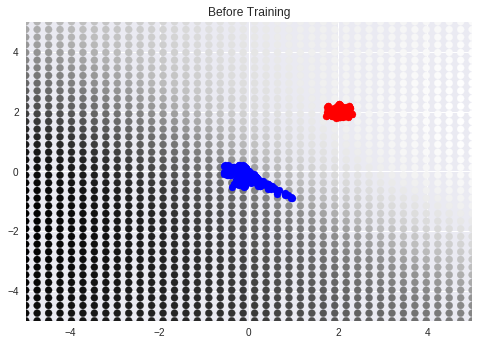

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab

import numpy as np
import lasagne
import theano
import theano.tensor as T
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
from scipy.stats import norm
import seaborn as sns
from IPython import display


    
def cords(M):
    #This function returns MxM coordinats between -5,5. Like "np.linspace|-5,5,M|" but as matrix
    
    numbers=np.linspace(0,10,M)
    x=list(np.zeros(M))
    y=list(np.linspace(0,10,M))
    for i in range(1,numbers.size):
        x+=list(np.ones(M)*numbers[i])
        y+=list(numbers)
    x=np.array(x)-5
    y=np.array(y)-5
    z=np.column_stack((x,y))
    return z


def sample_noise(M):
    #generate M random coordinates
    
    z1 = np.random.random(M)*2*area-area
    z2=np.random.random(M)*2*area-area

    z=np.column_stack((z1,z2))
    return z

def sample_normal(M):
    #generate M coordinates normally near mu=2
    
    x1 = np.float32(np.random.normal(mu, sigma, M))
    x2=np.float32(np.random.normal(mu, sigma, M))
    x=np.column_stack((x1,x2))
    return x


def plot_fig(generate, discriminate):
    # draw image
    
    axes = plt.gca()
    axes.set_xlim([-area, area])
    axes.set_ylim([-area, area])

    
    xs = np.linspace(-area, area, M)
    
    pointx = np.random.normal(mu,sigma,M)
    pointy = np.random.normal(mu,sigma,M)
    plt.scatter(pointx, pointy,c='r')

    zs = sample_noise(M)
    
    ds = discriminate(sample_noise(M*5))
    gs = generate(zs)
    
    cord_value=discriminate(cords(M_dis))[:,0]+discriminate(cords(M_dis))[:,1]
    
    plt.scatter(cordx,cordy,c=cord_value)
    plt.scatter(pointx, pointy,c='r')
    plt.scatter(gs[:,0],gs[:,1],c='b')
    #plt.hist(gs, bins=10, normed=True)


if __name__ == '__main__':
     
    area=5.0 #set image shape 
    mu = 2 #point near which we want generator to give points
    sigma = 0.1 #normal distribution arround mu
    M = 200 #batch size. In 'plot_fig' is used also as resolution. If you have powerfull device, you can increase it
    M_dis=40 #resolution for discriminator colormap. If you have powerfull device, you can increase it
    cordx=cords(M_dis)[:,0]
    cordy=cords(M_dis)[:,1]
    
    
    #Neuron networks:
    
    # generator
    G_input = T.matrix('Gx')
    G_l1 = lasagne.layers.InputLayer((None, 2), G_input)
    G_l2 = lasagne.layers.DenseLayer(G_l1, 40, nonlinearity=rectify)
    G_l3 = lasagne.layers.DenseLayer(G_l2, 20, nonlinearity=rectify)
    G_l4 = lasagne.layers.DenseLayer(G_l3, 2, nonlinearity=linear)
    G = G_l4

    G_out = lasagne.layers.get_output(G)
 
    
    # discriminators. We have two, one eats true values, another one eats generated values
    D1_input = T.matrix('D1x')
    D1_target = T.matrix('D1y')
    D1_l1 = lasagne.layers.InputLayer((None, 2), D1_input)
    D1_l2 = lasagne.layers.DenseLayer(D1_l1, 40, nonlinearity=tanh)
    D1_l3 = lasagne.layers.DenseLayer(D1_l2, 20, nonlinearity=tanh)
    D1_l4 = lasagne.layers.DenseLayer(D1_l3, 2, nonlinearity=sigmoid)
    D1 = D1_l4

    D2_l1 = lasagne.layers.InputLayer((None, 2), G_out)
    D2_l2 = lasagne.layers.DenseLayer(D2_l1, 40, nonlinearity=tanh, W=D1_l2.W, b=D1_l2.b)
    D2_l3 = lasagne.layers.DenseLayer(D2_l2, 20, nonlinearity=tanh, W=D1_l3.W, b=D1_l3.b)
    D2_l4 = lasagne.layers.DenseLayer(D2_l3, 2, nonlinearity=sigmoid, W=D1_l4.W, b=D1_l4.b)
    D2 = D2_l4

    D1_out = lasagne.layers.get_output(D1)
    D2_out = lasagne.layers.get_output(D2)

    # output functions
    discriminate = theano.function([D1_input], D1_out)
    generate = theano.function([G_input], G_out)
    
    
    # loss functions
    G_obj = (T.log(D2_out)).mean()
    D_obj = (T.log(D1_out) + T.log(1 - D2_out)).mean()

    # parameters update and training
    G_params = lasagne.layers.get_all_params(G, trainable=True)
    G_lr = theano.shared(np.array(0.01, dtype=theano.config.floatX)) #learning_rate
    G_updates = lasagne.updates.nesterov_momentum(1 - G_obj, G_params, learning_rate=G_lr, momentum=0.6)
    G_train = theano.function([G_input], G_obj, updates=G_updates)

    D_params = lasagne.layers.get_all_params(D1, trainable=True)
    D_lr = theano.shared(np.array(0.1, dtype=theano.config.floatX)) #learning_rate
    D_updates = lasagne.updates.nesterov_momentum(1 - D_obj, D_params, learning_rate=D_lr, momentum=0.6)
    D_train = theano.function([G_input, D1_input], D_obj, updates=D_updates)

    # that we have before training
    plot_fig(generate, discriminate)
    plt.title('Before Training')
    plt.show()   

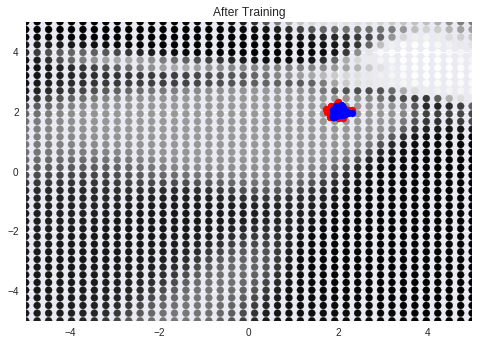

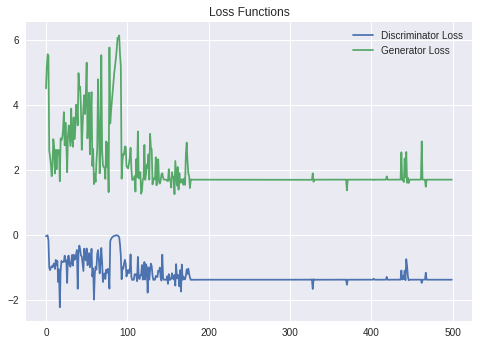

In [2]:
# training process
epochs = 500
histd, histg = np.zeros(epochs), np.zeros(epochs)
k = 20
plt.ion()
    
for i in range(epochs):
    for j in range(k):
        x = sample_normal(M)  # sampled m-batch from p_data
        z = sample_noise(M)  # sample m-batch from noise prior
        histd[i] = D_train(z, x)
    z = sample_noise(M)
    histg[i] = G_train(z)
    if i % 10 == 0:

        G_lr *= 0.99
        D_lr *= 0.99
        axes = plt.gca()
        axes.set_xlim([mu-1, mu+1])
        axes.set_ylim([mu-1, mu+1])
        plt.clf()
        plot_fig(generate, discriminate)
        plt.title('Training process. Step {} of {}'.format(i,epochs))
        plt.show()
        display.clear_output(wait=True)



plt.ioff()

plot_fig(generate, discriminate)
plt.title('After Training')
plt.show()

plt.clf()
plt.plot(range(epochs), histd, label='Discriminator Loss')
plt.plot(range(epochs), 1 - histg, label='Generator Loss')
plt.legend()
plt.title('Loss Functions')
plt.show()


